In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import time
import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [2]:
from configs.rnn_biogas import hparams
hparams = hparams()
print(hparams)

[('batch_size', 800), ('datagen', 'biogas'), ('in_seq_len', 24), ('input_channels', 1), ('input_dim', 5), ('lambd', 0.001), ('learning_rate', 0.01), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.99), ('neurons_unit', 64), ('norm_epsilon', 1e-12), ('num_layers', 1), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('test_split', 0.1), ('train_split', 0.8), ('val_split', 0.1)]


### Define Data Generator

In [3]:
from data_loader.biogas import *
get_fields = 'AT305'
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields)

### Define Model

In [4]:
def gru(units, name):
    # Use CuDNNGRU is GPU is available (provides a 3x speedup than GRU)
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_activation='tanh',
                                        recurrent_initializer='glorot_uniform',
                                        name=name)
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='tanh', 
                                   recurrent_initializer='glorot_uniform',
                                   name=name)

In [22]:
class Encoder(tf.keras.Model):
    def __init__(self, output_dim, units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.units = units
        #self.embedding = tf.keras.layers.Dense(units, activation='relu', name='encoder_affine_embedding')
        self.gru = gru(self.units, 'encoder_gru')
        #self.fc_out = tf.keras.layers.Dense(output_dim, activation='relu', name='encoder_affine_out')
        
    def call(self, x, hidden):
        #a = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        #x = self.fc_out(output)

        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

In [23]:
class Decoder(tf.keras.Model):
    def __init__(self, output_dim, units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.units = units
        self.embedding = tf.keras.layers.Dense(units, activation='tanh', name='decoder_affine_embedding')
        #self.gru = gru(self.units, 'decoder_gru')
        self.fc_out = tf.keras.layers.Dense(output_dim, activation='tanh', name='decoder_affine_out')
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.units, name='decoder_attn_W1')
        self.W2 = tf.keras.layers.Dense(self.units, name='decoder_attn_W2')
        self.V = tf.keras.layers.Dense(1, name='decoder_attn_V')
        
    def call(self, x, hidden, enc_output, mask):
        # enc_output shape == (batch_size, max_length, hidden_size)

        # score shape == (batch_size, max_length, 1)
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(tf.expand_dims(hidden, 1))))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        # output, state = self.gru(x)
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc_out(x) * mask
        
        return x
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

In [31]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, output_dim, num_layers, neurons_unit, batch_size, in_seq_len):
        super(Seq2Seq, self).__init__()
        self.output_dim   = output_dim
        self.num_layers   = num_layers
        self.neurons_unit = neurons_unit
        self.batch_size   = batch_size
        
        self.encoder = Encoder(output_dim, neurons_unit, hparams.batch_size)
        self.decoder = Decoder(output_dim, neurons_unit, hparams.batch_size)
            
    def call(self, inp, mask, trace=False):
        """
        Arguments:
            x: Inputs dataset
            out_seq_len: Number of steps to predict
        Returns:
            pred: Model predictions
        """
        if trace: import pdb; pdb.set_trace()

        # Step 1: Run encoder            
        hidden = self.encoder.initialize_hidden_state()
        enc_output, enc_hidden = self.encoder(inp, hidden)

        dec_hidden = enc_hidden

        dec_input = tf.concat((inp[:,0,:], tf.expand_dims(inp[:,-1,-1], 1)), axis=1)
        dec_input = tf.expand_dims(dec_input, 1)
        
        x = inp[:,-1:,-1:]

        # Step 2: Run decoder for t steps
        for t in range(0, inp.shape[1]):
            # passing enc_output to the decoder
            # out, dec_hidden = self.decoder(dec_input, dec_hidden, enc_output, mask[:,t:t+1])
            out = self.decoder(dec_input, enc_output[:,t], enc_output, mask[:,t:t+1])
            out = out + x
            dec_input = tf.concat((tf.expand_dims(inp[:,t,:],1), out), axis=2)
            
            if t == 0:
                outputs = out
            else:
                outputs = tf.concat([outputs, out], axis=1)
        return outputs

### Train Model
loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

Run a training session and print training statistics and model structure

In [36]:
loss, accuracy, run_time, stats = trainer.train_model(model_, optimizer_, dataset, hparams,
                                                      epochs=11, verbose=True, dev_dataset=dataset_val)

Epoch 1 Loss 0.0009 Accuracy 0.0003
Time taken for 1 epoch 20.1909 sec

Epoch 2 Loss 0.0009 Accuracy 0.0003
Time taken for 1 epoch 19.9141 sec

Epoch 3 Loss 0.0009 Accuracy 0.0003
Time taken for 1 epoch 20.2167 sec

Epoch 4 Loss 0.0009 Accuracy 0.0003
Time taken for 1 epoch 20.4748 sec

Epoch 5 Loss 0.0009 Accuracy 0.0003
Time taken for 1 epoch 20.0912 sec

Epoch 6 Loss 0.0008 Accuracy 0.0003
Time taken for 1 epoch 20.2538 sec

Epoch 7 Loss 0.0008 Accuracy 0.0003
Time taken for 1 epoch 20.3710 sec

Epoch 8 Loss 0.0008 Accuracy 0.0003
Time taken for 1 epoch 20.0892 sec

Epoch 9 Loss 0.0008 Accuracy 0.0003
Time taken for 1 epoch 20.2990 sec

Epoch 10 Loss 0.0008 Accuracy 0.0003
Time taken for 1 epoch 20.3318 sec

Epoch 11 Loss 0.0008 Accuracy 0.0003
Time taken for 1 epoch 20.0547 sec



Epoch 1 Loss 0.4251 Accuracy 0.4241
Time taken for 1 epoch 21.1492 sec

Epoch 2 Loss 0.0499 Accuracy 0.0489
Time taken for 1 epoch 20.3592 sec

Epoch 3 Loss 0.0194 Accuracy 0.0185
Time taken for 1 epoch 20.0808 sec

Epoch 4 Loss 0.0061 Accuracy 0.0053
Time taken for 1 epoch 20.3885 sec

Epoch 5 Loss 0.0032 Accuracy 0.0024
Time taken for 1 epoch 20.3395 sec

Epoch 6 Loss 0.0023 Accuracy 0.0016
Time taken for 1 epoch 20.2852 sec

Epoch 7 Loss 0.0015 Accuracy 0.0008
Time taken for 1 epoch 20.4195 sec

Epoch 8 Loss 0.0010 Accuracy 0.0003
Time taken for 1 epoch 20.2653 sec

Epoch 9 Loss 0.0010 Accuracy 0.0003
Time taken for 1 epoch 20.7215 sec

Epoch 10 Loss 0.0010 Accuracy 0.0003
Time taken for 1 epoch 21.9505 sec

Epoch 11 Loss 0.0010 Accuracy 0.0003
Time taken for 1 epoch 22.5199 sec

Loss 0.0010 Accuracy 0.0003 Time 228.4801


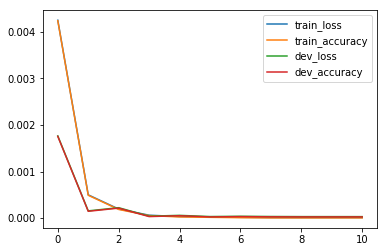

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  13824     
_________________________________________________________________
decoder_1 (Decoder)          multiple                  8962      
Total params: 22,786
Trainable params: 22,786
Non-trainable params: 0
_________________________________________________________________


In [32]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model_ = Seq2Seq(hparams.output_channels, hparams.num_layers, hparams.neurons_unit,
                            hparams.batch_size, hparams.in_seq_len)
optimizer_ = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model_, optimizer_, dataset, hparams,
                                                      epochs=11, verbose=True, dev_dataset=dataset_val)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 100, accuracy * 100, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.show()

trainer.save_model(model_, optimizer_, dataset_val, hparams, 'seq2attn' + get_fields.replace(' ', '_'), stats=stats)
model.summary()

### Make Predictions

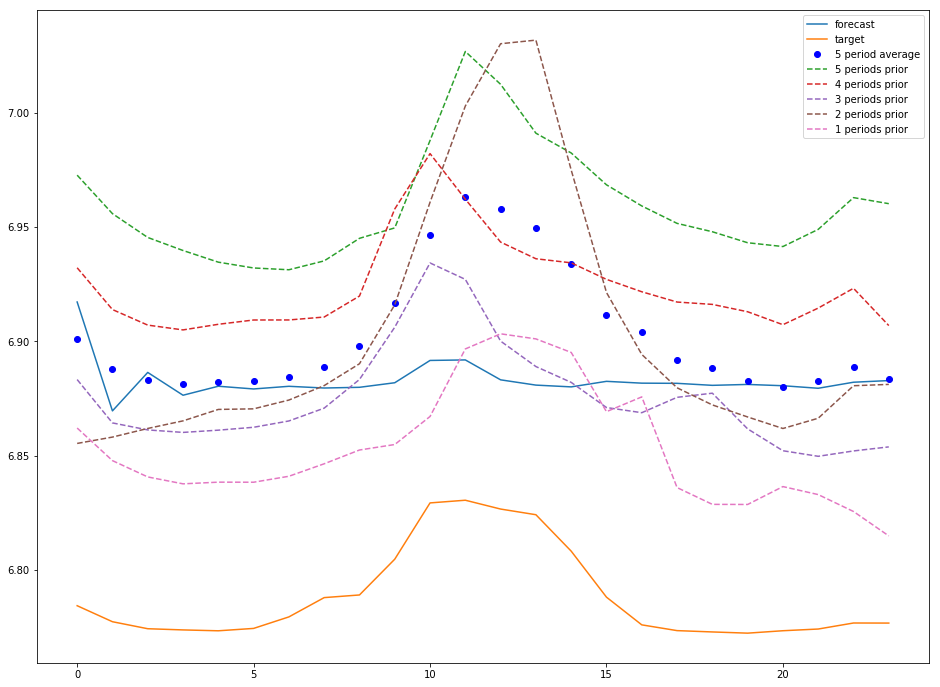

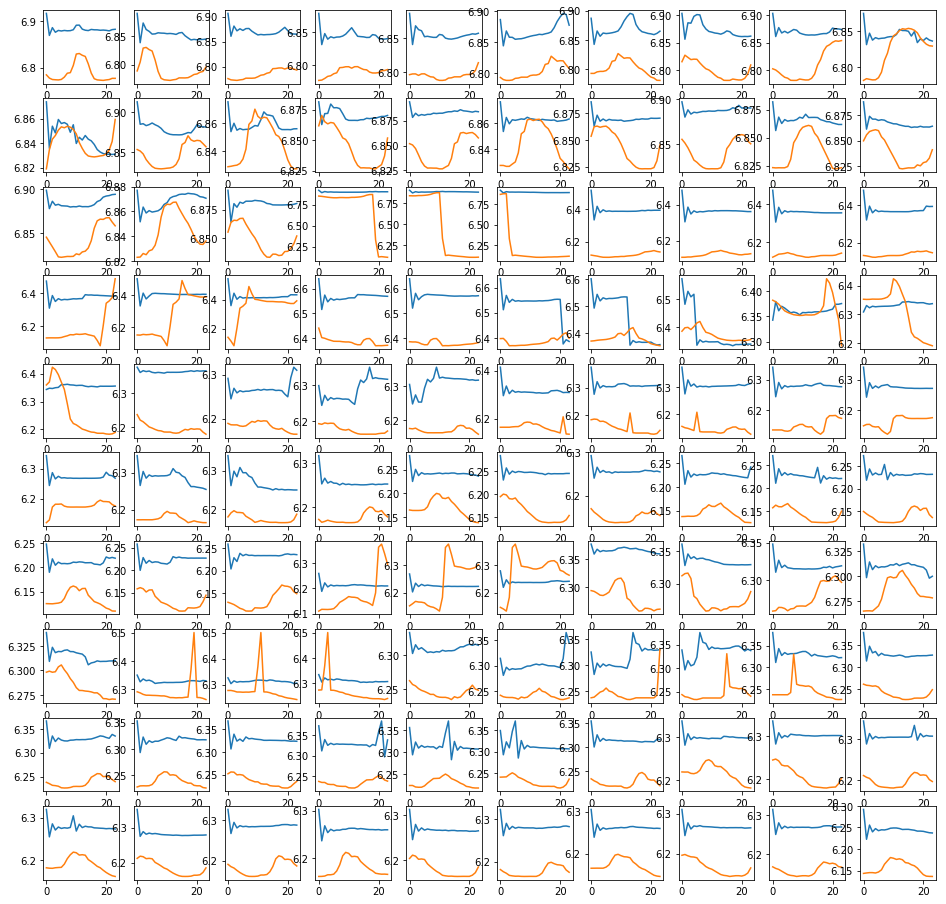

In [37]:
# show all sequences
# Select target sequence to show
TARGET_INDEX = 0

# Create forecast and rescale data
_, (inp, target, mask, x_max) = enumerate(dataset).__next__()
forecast = model_(inp, mask)
forecast *= tf.keras.backend.expand_dims(x_max)
target   *= tf.keras.backend.expand_dims(x_max)
inp = np.reshape(inp, [hparams.batch_size, hparams.in_seq_len, hparams.input_dim, hparams.input_channels])
inp *= np.reshape(x_max, [hparams.batch_size,1,1,-1])

# Plot target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX,:,0]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX,:,0]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX,:,0], 'bo', label='5 period average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i,0], '--', label='%i periods prior' % (5-i))
plt.legend()
plt.show()

# Plot specimen sequences
plt.figure(figsize=(16,16))
for i in range(0,800,8):
    ax = plt.subplot(10,10,i/8+1)
    ax.plot(np.squeeze(forecast[i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

In [ ]:
total_accuracy = []

for i, (inp, target, mask) in enumerate(dataset_val):
    forecast = []

    hidden = encoder.initialize_hidden_state()
    enc_output, enc_hidden = encoder(inp[:, START_POINT:], hidden)

    dec_hidden = enc_hidden

    dec_input = tf.concat((inp[:,0,:], tf.expand_dims(inp[:,-1,-1], 1)), axis=1)
    dec_input = tf.expand_dims(dec_input, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, target.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output, mask[:,t:t+1])
        forecast.append(np.squeeze(predictions))

        # using teacher forcing - adapted to feed predictions
        dec_input = tf.concat((tf.expand_dims(inp[:,t,:],1), predictions), axis=2)

    accuracy = (np.array(forecast).T - target[:,:23,0]) * x_max
    accuracy = accuracy ** 2 / x_var
    accuracy = np.mean(accuracy, axis=0)
    
    total_accuracy.append(accuracy)

model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))
    
print('Total Accuracy: %.4f' % np.mean(total_accuracy))
plt.plot(np.mean(total_accuracy, axis=0))
plt.show()

In [ ]:
plt.figure()
for t, data in model_accuracy:
    plt.plot(data, label = 'Training Set: %i hrs' % t)
plt.legend()
plt.xlabel('Forecast Horizon (hours)')
plt.ylabel('Relative Squared Error')
plt.title('Encoder-Decoder Network')
plt.plot()

### Test Hyperparameters

In [ ]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

#for _ in range(25):
#   lr = np.random.uniform(-8, -1, 1):
#   nodes = np.floor(2 ** np.random.randint((3,9))):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    encoder = Encoder(hparams.output_dim, int(nodes), hparams.batch_size)
    decoder = Decoder(hparams.output_dim, int(nodes), hparams.batch_size)
    optimizer = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        train_model((encoder, decoder), optimizer, dataset, hparams, epochs = 5, verbose=False)
    print('Learning Rate {:.4f} Nodes {} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(\
                lr, nodes, loss*100, accuracy * 100, run_time))
    
    models.append((encoder,decoder))
    stats.append(stat)

In [ ]:
# show all sequences
plt.figure(figsize=(16,12))
plt.plot(np.sum(forecast, axis=1), label='forecast')
plt.plot(np.sum(target, axis=0), label='target')
plt.plot(np.sum(inp, axis=0).mean(axis=1), 'bo', label='5yr average')
plt.plot(np.sum(inp, axis=0), '+', label='history')
plt.legend()
plt.show()

In [ ]:
l_ = np.sum((forecast.T - np.squeeze(target)[:,:-1]) ** 2, axis=1)
l_.argsort()

In [ ]:
loss = np.mean((forecast.T*8.15 - target[:,1:,0]*8.15) ** 2 / dataset.var(), axis=0)
plt.plot(loss)
plt.show()

Adapted from examples contained in the official Tensorflow github repo;
<href>https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb</href>